In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os
import numpy as np
import glob2 as glob



# Downloading Data and creating Dataloader

In [2]:
#transforms
transform = transforms.Compose([transforms.ToTensor()])

# Downloading Dataset MNIST and DataLoader
mnist_data = datasets.MNIST('./data', train=True, download=False, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)


# Analysing Dataset

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
# 
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# MODEL
### Linear AutoEncoder Model: 

In [4]:
class Linear_encoder(nn.Module):
    def __init__(self):
        super(Linear_encoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Linear(28 * 28, 128),    # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),         # N, 128 -> N, 64
            nn.ReLU(),
            nn.Linear(64, 12),          # N, 64  -> N, 12
            nn.ReLU(),
            nn.Linear(12, 3)            # N, 12  -> N, 3
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),          
            nn.ReLU(),
            nn.Linear(64, 128),         
            nn.ReLU(),
            nn.Linear(128, 28 * 28),    
            nn.Sigmoid()                # N, 3   -> N, 784
            # compress to a range (0, 1) 
            # # Sigmoid function is used to convert linear values to probabilities
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Convolutional AutoEncoder Model:

In [5]:
class Cnn_encoder(nn.Module):
    def __init__(self):
        super(Cnn_encoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Defining Hyperparameters

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
linear_encoder = Linear_encoder().cuda(device)
cnn_encoder = Cnn_encoder().cuda(device)

# Loss and optimizer
criterion = nn.MSELoss()
linear_optim = torch.optim.Adam(linear_encoder.parameters(), lr=0.001, weight_decay=1e-5)
cnn_optim = torch.optim.Adam(cnn_encoder.parameters(), lr=0.001, weight_decay=1e-5)

# Training
### Training Function:

In [7]:
def training(num_epoch, model, optimizer, criterion, data_loader):
    outputs = []
    for epoch in range(num_epoch):
        for batch_idx, (image, _) in enumerate(data_loader):
            if model.__class__.__name__ == 'Linear_encoder':
                image = image.reshape(-1, 28*28).cuda(device)
            elif model.__class__.__name__ == 'Cnn_encoder':
                image = image.cuda(device)
            # ===================forward=====================
            generated_img = model(image)
            loss = criterion(generated_img, image)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'Epoch: {epoch+1}, loss:{loss.item():.4f}')
        outputs.append((epoch, image, generated_img))
    return outputs

### Actual Training:

In [8]:
num_epoch = 1000
print("======================= LINEAR =======================")
linear_output = training(num_epoch, linear_encoder, linear_optim, criterion, data_loader)
print("======================== CNN =========================")
cnn_output = training(num_epoch, cnn_encoder, cnn_optim, criterion, data_loader)

======================= LINEAR =======================
Epoch: 1, loss:0.0461
Epoch: 2, loss:0.0429
Epoch: 3, loss:0.0418
Epoch: 4, loss:0.0429
Epoch: 5, loss:0.0364
======================== CNN =========================
Epoch: 1, loss:0.0091
Epoch: 2, loss:0.0054
Epoch: 3, loss:0.0042
Epoch: 4, loss:0.0038
Epoch: 5, loss:0.0036


# Visualizing Results

In [9]:
# clearing results folder
for f in glob.glob('results/*'): os.remove(f)

======================= LINEAR =======================


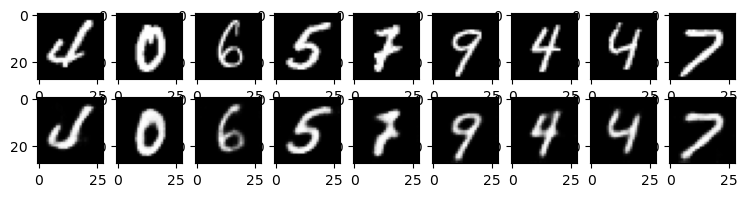

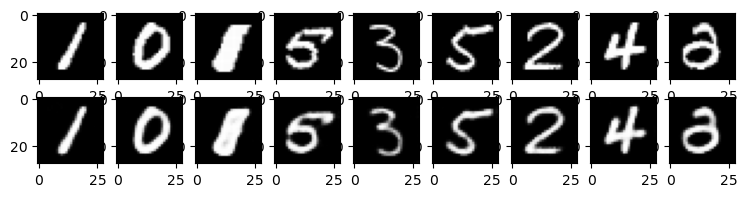

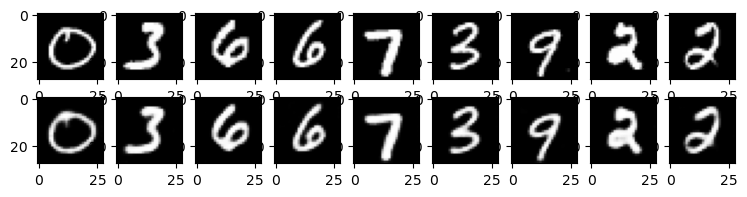

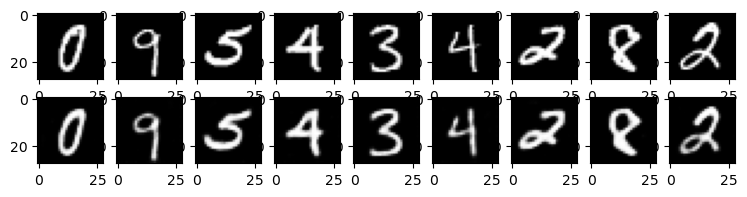

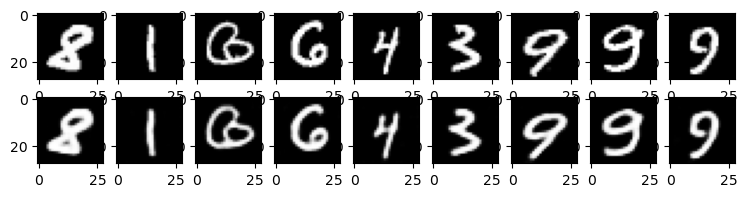

In [10]:
def plot_results(flag, outputs, num_epochs, interval):
    for k in range(0, num_epochs, interval):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = outputs[k][1].detach().cpu().numpy()
        recon = outputs[k][2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i + 1)
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
        
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9 + i + 1)
            item = item.reshape(-1, 28, 28)
            plt.imshow(item[0])
    
        plt.savefig(f'results/{flag}_epoch_set_{k}.png')
    return None

In [ ]:
print("======================= LINEAR =======================")
plot_results('linear', cnn_output, num_epoch, 100)

======================= CNN =======================


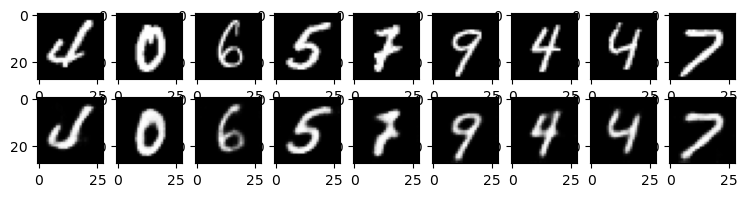

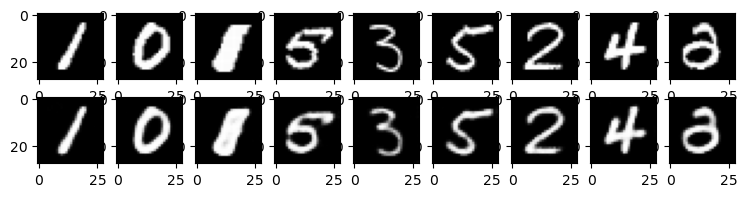

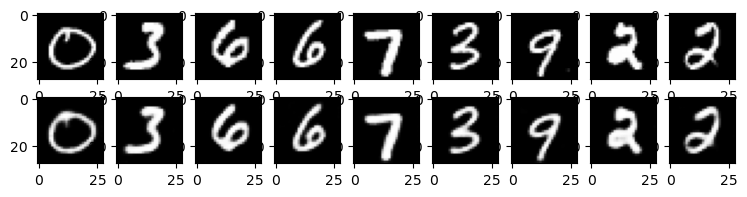

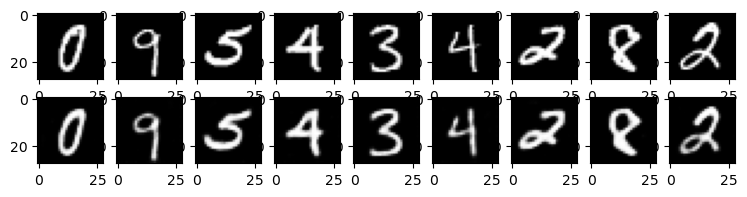

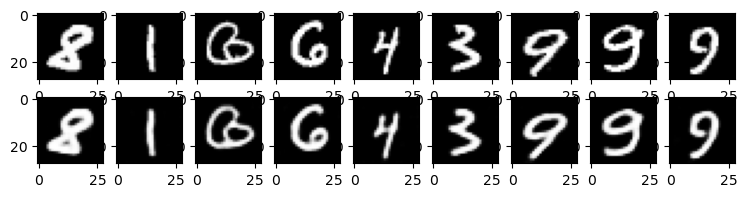

In [11]:
print("======================= CNN =======================")
plot_results('cnn', cnn_output, num_epoch, 100)